# URL classification project 


# Project Setup

In [ ]:
import sklearn
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from google.colab import files
from google.colab import drive  #this import is used to get the dataset< which is stored in my google drive account
drive.mount("/content/gdrive")
pd.set_option('display.max_columns', None) #display all the columns in pandas head function

np.random.seed(42)
tf.random.set_seed(42)

from urllib.parse import urlparse,urlencode
import ipaddress
import re
import requests
import seaborn as sns

Mounted at /content/gdrive


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import  cross_val_score, StratifiedKFold


random_state = 42
cv_results = np.array([])
cv_means = []
cv_std = []
cvk=10

In [ ]:
#getting the data from google drive
df =pd.read_csv('/content/gdrive/My Drive/datasets/Mlprojdataset.csv')
#df.drop("Unnamed: 0",axis=1,inplace=True)
#in case you are using local machine
#df =pd.read_csv('./malicious_phish.csv')

In [ ]:
!python -V

Python 3.7.15


# Overview of the Dataset

Let begin our analysis by looking at the dataset

In [ ]:
#df.drop("Unnamed: 0",axis=1,inplace=True)
df.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [ ]:
df.shape

(651191, 2)

As can be seen the dataset is composed of many rows (instances), but it has only two columns and one of these two columns is the target value, which only leave one column for us to train our model.
ofcourse this is infeasible, therefore we will conduct feature extraction from the first column before we do anything else inorder to make our model work

but before we begin the feature extraction process let see the distribution of our labels

In [ ]:
df["type"].describe()

count     651191
unique         4
top       benign
freq      428103
Name: type, dtype: object

In [ ]:
df["type"].value_counts()


benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

([<matplotlib.patches.Wedge at 0x7f294ebf1c10>,
 [Text(-0.5220846877148526, 0.9682084377104369, 'Benign'),
  Text(-0.12773036260591056, -1.0925589020590893, 'Defacement'),
  Text(0.7913806562888462, -0.7640135187624859, 'Phishing'),
  Text(1.0864899607286258, -0.1718707806344909, 'Malware')])

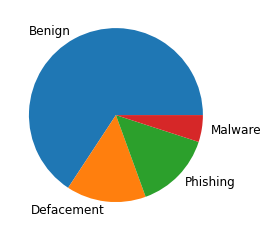

In [ ]:
lis=[df["type"].value_counts()[0],df["type"].value_counts()[1],df["type"].value_counts()[2],df["type"].value_counts()[3]]
plt.pie(lis,labels=["Benign","Defacement","Phishing","Malware"])


As can be seen above we have four classes, which means our task is considered to be a multi-class task, further more the "benign" label is the label with the most occurance, so we will need to take that into our consideration when we evaluate our model

# URL Components

URLS conisists minimally of three components and up to 9 componenets in the case of complex URLs

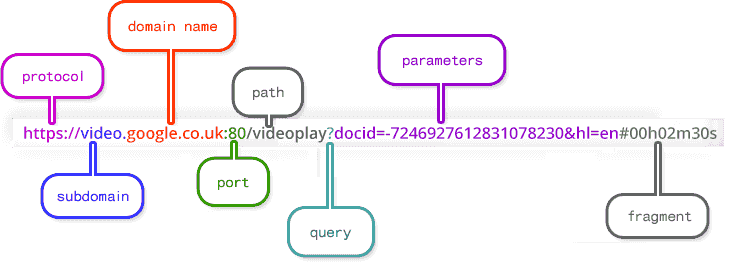

Figure source:https://medium.com/@joseph.pyram/9-parts-of-a-url-that-you-should-know-89fea8e11713



As can be seen from the figure above, these are the components of a complex url, the URL in shown in the figure is a special case where all of the components are shown, in the general case 5 of such components is present in a URL, because the domain part and the sub domain part are typically both treated as one and is called the domain name, the port is rarely present in a url. The same thing applies for the query as its typically results from user interaction for example searching for something in google

We will extract the six most relevant components  of the above components from our URLs datasets namely:

1- The protocol

2-The domain name (subdomain + domain)

3- The path

4- The parameters

5-The query

6- The fragment

After extracting these componenets more features will be extracted from it

# URL Components Extraction

In [ ]:
df["original_url"]=df["url"]

In [ ]:
def fix_url(url): #if no protocol (scheme) is used assume the general case of http, this is needed to make the urlparse function works
  if not urlparse(url).scheme:
        return f"http://{url}"
  return url

In [ ]:
def get_protocol(url):
  protocol, _, _, _, _, _ = urlparse(url.replace("[","").replace("]","").strip() )
  return protocol

In [ ]:
def get_host(url):
  _, host, _, _, _, _ = urlparse(url.replace("[","").replace("]","").strip())
  return host

In [ ]:
def get_path(url):
  _, _, path, _, _, _ = urlparse(url.replace("[","").replace("]","").strip())
  return path

In [ ]:
def get_parameters(url):
  _, _, _, parameters, _, _ = urlparse(url.replace("[","").replace("]","").strip())
  return parameters

In [ ]:
def get_query(url):
  _, _, _, _, query, _ = urlparse(url.replace("[","").replace("]","").strip())
  return query

In [ ]:
def get_fragment(url):
  _, _, _, _, _, fragment = urlparse(url.replace("[","").replace("]","").strip())
  return fragment

In [ ]:
df["url"]=df["url"].apply(fix_url)

In [ ]:
df["protocol"]=df["url"].apply(get_protocol)
df["host"]=df["url"].apply(get_host)
df["path"]=df["url"].apply(get_path)
df["parameters"]=df["url"].apply(get_parameters)
df["query"]=df["url"].apply(get_query)
df["fragment"]=df["url"].apply(get_fragment)

In [ ]:
df.head()

,url,type,original_url,protocol,host,path,parameters,query,fragment
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br,,,,
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com,/music/krizz_kaliko.html,,,
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org,/rexroth/cr/1.htm,,,
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be,/index.php,,option=com_content&view=article&id=70&vsig70_0=15,
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net,/index.php,,option=com_mailto&tmpl=component&link=aHR0cDov...,


Now that we have extracted all the components, let analyze it to see which components is revelant to our analysis

In [ ]:
df = df.replace('', np.nan) #fill empty values with Nan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   url           651191 non-null  object
 1   type          651191 non-null  object
 2   original_url  651191 non-null  object
 3   protocol      651191 non-null  object
 4   host          651007 non-null  object
 5   path          628146 non-null  object
 6   parameters    325 non-null     object
 7   query         139969 non-null  object
 8   fragment      461 non-null     object
dtypes: object(9)
memory usage: 44.7+ MB


As can be seen the Parameters , Query and Fragment has many empty values, therefore we can safely drop such a features.

The host (domain name) part has 183 empty values, having a url with no domain name doesn't make alot of sense in our project, also 183 is relatively a small amount compared to the whole dataset, therefore we can safely drop all the instance that has no domain name

In [ ]:
df.drop(['parameters', 'query','fragment'], axis = 1,inplace=True)
df.dropna(subset = ['host'],inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 651008 entries, 0 to 651190
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   url           651008 non-null  object
 1   type          651008 non-null  object
 2   original_url  651008 non-null  object
 3   protocol      651008 non-null  object
 4   host          651008 non-null  object
 5   path          627962 non-null  object
dtypes: object(6)
memory usage: 34.8+ MB


Finally the Path part also has some missing values;however it consistes a huge portion of our datasets,also having such an empty path in a url is normal for example "www.google.com",therefore we will fill these empty values with spaces,as this will not affect the next process as we will see soon.

In [ ]:
df.fillna("",inplace=True)

In [ ]:
df.reset_index(drop=True,inplace=True)

# Feature Extraction

We will begin our feature extraction journey by extracting features related to the whole URL itself, after that more features will be extracted for every component individually

# URL Features

**Presense of an IP address in the URL**

Every website has an IP address associated with it, which is simpliy used to tell your device where to direct it's requests. most websites has a Domain name assosiated with it's IP to make it easier for us (as humans) to remeber how to access a certain website.

every website is accessable using either its IP address of it name, and here we will check whether a URL in the dataset is IP or name based:

In [ ]:
def ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

df['ip_address'] = df['url'].apply(ip_address)

**Special symbols in the URL**

Most of the time malicious URLs contains specail symbols that might alter how the bowser treats such URL, for example the "@" symbol leads the browser to ignore everything preceding it, which means that the real address where you will be redirected is ofter after such symbol, hence an attacker can inject the name of a legitimate URL before it to trick you into visiting such website.


Another popularly used symbol is the " - " which is rarely used in legitimate websites, but used alot in malicious ones inorder to make the domain name looks good for the user and remove an suspiciousness that the user might have, or to trick the user into beliveing that he is visiting a legitimate website.
for example a malicious website that imitate the facebook might look like this
"www.face-book.com", unless the user is carefull, he can fall easliy in such simple trick.

The following is a list of some popularly used symbols in URLs

  ?    -  =   .    #    %   +    $  !  *  ,

In [ ]:
def specialSymbols(df):

  symbolsList = ['_','&','~','"',"'",'@','?','-','=','.','#','%','+','$','!','*',',','//','/',';',':','>','<','^','[',']','{','}','(',')']
  for symbol in symbolsList:
     df[f"URL_{symbol}"] = df['url'].apply(lambda i: i.count(symbol))

specialSymbols(df)

**Length of the URL**

The official length of a URL is 2048 characters, so regardless whether a URL is malicious or not, it has to obay this rule.
Begnin websites normally uses short URLs, on the otherside some malicious websites uses long URLs to hide some information such as the special symbols mentioned above, therefore such feature might be useful in our analysis

In [ ]:
def getLength(url):
  return len(url)

In [ ]:
df["length"] = df["url"].apply(getLength)

**Usage of a URL Shortening Services**

Using URL Shortening Services is a third party websites that is used to convert long URLs in short ones using the http redirect on the domain name of the shorting service website.

such service is used by many attackers to hide some of the info in the original URL (the long URL), and to trick the users into beliving that the website is safe,as theses services is seen alot by the users in thier daily browsing.

In [ ]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df['Shortining'] = df['url'].apply(Shortining_Service)

**Digits counts in a URL**



In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [ ]:
df['digits_in_url']= df['url'].apply(digit_count)

**letters counts in a URL**

It might also be useful to include the letter count in our analysis,if this feature turns out to be useless we can always drop it out


In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [ ]:
df['letters_in_url']= df['url'].apply(letter_count)

**E-mail Address in URL**

It's pretty rare to find an E-mail address inside of a websites URL, most big websites avoid having an E-mail address inside any of thier URLs to protect the users privacy and to protect the users from spam bots that might detect such E-mails and start sending advertisments to it, therefore having an E-mail inside a URL might be a good indication about the type of the URL that a person might visit.

In [ ]:
def EmailAddress(url):
    if re.findall(r'[\w\.-]+@[\w\.-]+', url):
        return 1
    else:
        return 0

df['email_address']= df['url'].apply(EmailAddress)

**Counting vowels**

In [ ]:
def vowels_count(url):
    vowels = ['a', 'e', 'i', 'o', 'u']
    count = 0
    for i in vowels:
        count += url.lower().count(i)
    return count




In [ ]:
df['vowels_url']= df['url'].apply(vowels_count)

**TLD count**

A top-level domain is a group of letters that appear as part of a website address URL, for exmaple if we have the following URL : "www.google.com", the TLD is ".com" , it is mainly used for DNS resolving.

Typically a website might has 1 or 2 TLDs in its URL.

In this feature we have a list of all of the possible TLDs, and will use it to count the TLDs inside of a URL

In [ ]:
tld_file = open('/content/gdrive/My Drive/datasets/tld.txt', 'r') #displaying the TLDs list

print(tld_file.readlines() )

tld_file.close()

['# Version 2022042900, Last Updated Fri Apr 29 07:07:01 2022 UTC\n', 'AAA\n', 'AARP\n', 'ABARTH\n', 'ABB\n', 'ABBOTT\n', 'ABBVIE\n', 'ABC\n', 'ABLE\n', 'ABOGADO\n', 'ABUDHABI\n', 'AC\n', 'ACADEMY\n', 'ACCENTURE\n', 'ACCOUNTANT\n', 'ACCOUNTANTS\n', 'ACO\n', 'ACTOR\n', 'AD\n', 'ADAC\n', 'ADS\n', 'ADULT\n', 'AE\n', 'AEG\n', 'AERO\n', 'AETNA\n', 'AF\n', 'AFL\n', 'AFRICA\n', 'AG\n', 'AGAKHAN\n', 'AGENCY\n', 'AI\n', 'AIG\n', 'AIRBUS\n', 'AIRFORCE\n', 'AIRTEL\n', 'AKDN\n', 'AL\n', 'ALFAROMEO\n', 'ALIBABA\n', 'ALIPAY\n', 'ALLFINANZ\n', 'ALLSTATE\n', 'ALLY\n', 'ALSACE\n', 'ALSTOM\n', 'AM\n', 'AMAZON\n', 'AMERICANEXPRESS\n', 'AMERICANFAMILY\n', 'AMEX\n', 'AMFAM\n', 'AMICA\n', 'AMSTERDAM\n', 'ANALYTICS\n', 'ANDROID\n', 'ANQUAN\n', 'ANZ\n', 'AO\n', 'AOL\n', 'APARTMENTS\n', 'APP\n', 'APPLE\n', 'AQ\n', 'AQUARELLE\n', 'AR\n', 'ARAB\n', 'ARAMCO\n', 'ARCHI\n', 'ARMY\n', 'ARPA\n', 'ART\n', 'ARTE\n', 'AS\n', 'ASDA\n', 'ASIA\n', 'ASSOCIATES\n', 'AT\n', 'ATHLETA\n', 'ATTORNEY\n', 'AU\n', 'AUCTION\n', 'AUD

In [ ]:
tld_file = open('/content/gdrive/My Drive/datasets/tld.txt', 'r')
def TLD_count(url):
    tldcount = 0
    tld_list=tld_file.readlines()
    line=0
    while (line < len(tld_list)):
       if tld_list[line].rstrip() in url :
          tldcount+=1
          line+=10
       line+=1
    if(".php" in url):
      tldcount-=1;
    if(".html" in url):
      tldcount-=1;

    tld_file.seek(0)
    return tldcount

df['tld_count']= df['url'].apply(TLD_count)


KeyboardInterrupt: ignored

**Precense of the word 'Server' or 'Client'**

In [ ]:
def check_word_server_client(url):
    if "server" in url.lower() or "client" in url.lower():
        return 1
    return 0
df['server_client']= df['url'].apply(check_word_server_client)

**protocol type**

in our dataset we have three types of protocols ,http, https, and ftp, for each of such protocols we will create a feature that indicates if the url uses such protocol

we will not use the protocol feature that we extracted here because we filled the urls that doesn't contain any url with http to make the urlparse function work.

**Usage of https**

https (Hyper Text Transfer Protocol Secure) is a protocol built on the http protocol with the addition of an encryption layer, which means that the connection between your browser and the target website is secure and can not be intercepted by a malicious entity, it is a common misunderstanding nowadays that all https websites are safe, this is true in term of the connection only,not the website itself as anyone could implement such protocol easily in his website to trick users into entering it.

In [ ]:
def https(url):
    if str(urlparse(url).scheme)=='https':
        return 1
    else:
        return 0

df['https'] = df['original_url'].apply(https)

In [ ]:
def http(url):
    if str(urlparse(url).scheme)=='http':
        return 1
    else:
        return 0

df['http'] = df['original_url'].apply(http)

In [ ]:
def ftp(url):
    if str(urlparse(url).scheme)=='ftp':
        return 1
    else:
        return 0

df['ftp'] = df['original_url'].apply(ftp)

# Path Features

As for the path features we will extract simillar features as the ones we extracted for the URL

In [ ]:
def specialSymbols2(df):

  symbolsList = ['_','&','~','"',"'",'@','?','-','=','.','#','%','+','$','!','*',',','//','/',';',':','>','<','^','[',']','{','}','(',')']
  for symbol in symbolsList:
     df[f"path_{symbol}"] = df['path'].apply(lambda i: i.count(symbol))

specialSymbols2(df)

In [ ]:
df["path_length"] = df["path"].apply(getLength)
df['path_digits_in_url']= df['path'].apply(digit_count)
df['path_letters_in_url']= df['path'].apply(letter_count)
df['path_vowels_url']= df['path'].apply(vowels_count)


# Host Features

**Digits counts in a domain name**

Digits inside a URL's domain can also be an indication of the status of a website in term of it being benigin or not,a malicious entity can use numarical digits inorder to trick the user into beliving that he is visiting a normal website.
for example an attacker might make a website with the following URL "www.facebo0k.com", notice that the second "o" is actually a zero, and anyone can easily fall in this simple trick.

In [ ]:
def specialSymbols3(df):

  symbolsList = ['_','&','~','"',"'",'@','?','-','=','.','#','%','+','$','!','*',',','//','/',';',':','>','<','^','[',']','{','}','(',')']
  for symbol in symbolsList:
     df[f"host_{symbol}"] = df['host'].apply(lambda i: i.count(symbol))

specialSymbols3(df)

In [ ]:
df["host_length"] = df["host"].apply(getLength)
df['host_digits_in_url']= df['host'].apply(digit_count)
df['host_letters_in_url']= df['host'].apply(letter_count)
df['host_vowels_url']= df['host'].apply(vowels_count)

In [ ]:
df.info()

# Feature Engineering

Now that we have extracted all the features that we need, let take a look at it once again

In [ ]:
df.head()

,url,type,original_url,protocol,host,path,ip_address,URL__,URL_&,URL_~,"URL_""",URL_',URL_@,URL_?,URL_-,URL_=,URL_.,URL_#,URL_%,URL_+,URL_$,URL_!,URL_*,"URL_,",URL_//,URL_/,URL_;,URL_:,URL_>,URL_<,URL_^,URL_[,URL_],URL_{,URL_},URL_(,URL_),length,Shortining,digits_in_url,letters_in_url
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br,,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,0,0,23,0,0,17
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com,/music/krizz_kaliko.html,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,4,0,1,0,0,0,0,0,0,0,0,0,42,0,1,33
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org,/rexroth/cr/1.htm,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,5,0,1,0,0,0,0,0,0,0,0,0,38,0,1,29
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be,/index.php,0,2,3,0,0,0,0,1,1,4,3,0,0,0,0,0,0,0,1,3,0,1,0,0,0,0,0,0,0,0,0,88,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net,/index.php,0,1,2,0,0,0,0,1,1,3,2,0,0,0,0,0,0,0,1,3,0,1,0,0,0,0,0,0,0,0,0,235,0,22,199


In [ ]:
df.describe()

,ip_address,URL__,URL_&,URL_~,"URL_""",URL_',URL_@,URL_?,URL_-,URL_=,URL_.,URL_#,URL_%,URL_+,URL_$,URL_!,URL_*,"URL_,",URL_//,URL_/,URL_;,URL_:,URL_>,URL_<,URL_^,URL_[,URL_],URL_{,URL_},URL_(,URL_),length,Shortining,digits_in_url,letters_in_url,email_address,vowels_url,tld_count,server_client,https,http,ftp,path__,path_&,path_~,"path_""",path_',path_@,path_?,path_-,path_=,path_.,path_#,path_%,path_+,path_$,path_!,path_*,"path_,",path_//,path_/,path_;,path_:,path_>,path_<,path_^,path_[,path_],path_{,path_},path_(,path_),path_length,path_digits_in_url,path_letters_in_url,path_vowels_url,host__,host_&,host_~,"host_""",host_',host_@,host_?,host_-,host_=,host_.,host_#,host_%,host_+,host_$,host_!,host_*,"host_,",host_//,host_/,host_;,host_:,host_>,host_<,host_^,host_[,host_],host_{,host_},host_(,host_),host_length,host_digits_in_url,host_letters_in_url,host_vowels_url
count,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.00000,651008.000000,651008.000000,651008.000000,651008.0,651008.000000,651008.000000,651008.000000,651008.0,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.0,651008.0,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.0,651008.000000,651008.000000,651008.000000,651008.0,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000,651008.0,651008.0,651008.0,651008.00000,651008.000000,651008.000000,651008.000000,651008.000000,651008.0,651008.0,651008.000000,651008.000000,651008.00000,651008.000000,651008.000000,651008.000000,651008.000000,651008.000000
mean,0.019166,0.422953,0.380547,0.013445,0.000058,0.013467,0.002220,0.223807,1.550744,0.603942,2.195282,0.000871,0.519617,0.068449,0.000238,0.000954,0.000395,0.004825,1.003750,4.372865,0.038866,1.053534,0.000075,0.000078,0.000129,0.002416,0.002416,0.000284,0.000289,0.006083,0.006066,65.136717,0.061053,5.526868,48.093569,0.001676,15.255049,1.536204,0.004094,0.024086,0.264693,0.000003,0.286130,0.003359,0.01331,0.000003,0.002625,0.000885,0.0,1.284225,0.009258,0.509875,0.0,0.378215,0.045325,0.000078,0.000484,0.000178,0.004049,0.001528,2.317033,0.001045,0.004805,0.000015,0.000017,0.000023,0.0,0.0,0.000008,0.000017,0.005650,0.005645,28.785132,3.057886,20.848228,7.151132,0.000198,0.000028,0.000026,0.000040,0.006028,0.000029,0.0,0.133432,0.000026,1.599297,0.0,0.000149,0.000041,0.000022,0.000029,0.000031,0.0,0.0,0.0,0.00002,0.007642,0.000026,0.000026,0.000040,0.0,0.0,0.000029,0.000025,0.00002,0.000029,17.396537,0.632018,15.015255,5.347526
std,0.137107,1.173669,1.224232,0.117718,0.011359,0.161296,0.054191,0.441242,2.974102,1.517069,1.490810,0.032331,4.462867,0.621361,0.023547,0.039552,0.074949,0.152449,0.068603,1.650446,0.558556,0.302790,0.014821,0.014293,0.018299,0.050240,0.050026,0.018753,0.018794,0.083839,0.083574,43.663181,0.239428,11.701520,31.057751,0.040903,10.265226,0.892384,0.063851,0.153315,0.441170,0.001753,1.067911,0.105469,0.11650,0.001753,0.053459,0.032591,0.0,2.874578,0.141742,0.695817,0.0,3.755902,0.508943,0.010443,0.029194,0.068312,0.142919,0.039534,1.566977,0.057459,0.086553,0.006072,0.006197,0.007539,0.0,0.0,0.002771,0.004469,0.080027,0.080017,27.999433,7.077717,19.804346,7.349747,0.015822,0.006072,0.

As can be seen some of the features above has only zero values, therefore we will be dropping it as it will be useless for our model


In [ ]:
df.drop(["path_?","path_#","path_[","path_]","host_?","host_#","host_,","host_//","host_/","host_[","host_]",],axis=1,inplace=True)

The Protocol attribute should also be dropped as we have already expanded it to three features :http, https, ftp

In [ ]:
df.drop(["protocol"],axis=1,inplace=True)

we also need to drop the categorical columns such as the url , host, path, as we have already extracted the features that we need from it

In [ ]:
df.drop(["url","path","host","original_url"],axis=1,inplace=True)

It can be seen that some of the features has a really low mean, this indicates that such features rarely appeares in any URL, Therefore we will merge some of these features together to reduce the dimensionality

In [ ]:
df["host_><^{}()!;:~"]=df["host_<"]+df["host_>"]+df["host_^"]+df["host_}"] +df["host_{"]+df["host_("] +df["host_)"]+df["host_!"]+df["host_;"]+df["host_:"]+df["host_~"]
df.drop(["host_<","host_>","host_^","host_}","host_{","host_(","host_)","host_!","host_:","host_;"],axis=1,inplace=True)

In [ ]:
df["path_><^{}()!;:'~"]=df["path_<"]+df["path_>"]+df["path_^"]+df["path_}"] +df["path_{"]+df["path_("] +df["path_)"]+df["path_!"]+df["path_;"]+df["path_:"]+df["path_'"]+df['path_"']+df['path_~']
df.drop(["path_<","path_>","path_^","path_}","path_{","path_(","path_)","path_!","path_:","path_;",'path_"',"path_'",'path_~'],axis=1,inplace=True)

In [ ]:
df["URL_><^{}()[]!;:'~"]=df["URL_<"]+df["URL_>"]+df["URL_^"]+df["URL_}"] +df["URL_{"]+df["URL_("] +df["URL_)"]+df["URL_["]+df["URL_]"]+df["URL_!"]+df["URL_;"]+df["URL_:"]+df["URL_'"]+df['URL_"']+df['URL_~']
df.drop(["URL_<","URL_>","URL_^","URL_}","URL_{","URL_(","URL_)","URL_!","URL_:","URL_;","URL_[","URL_]","URL_'",'URL_"','URL_~'],axis=1,inplace=True)

In [ ]:
df['https+ftp']=df['https']+df['ftp']
df.drop(["https","ftp"],axis=1,inplace=True)

Finally we need to encode our labels inorder to be able to feed it into the ML algorithms

In [ ]:
df["type"] = df["type"].astype('category')
df["type"] = df["type"].cat.codes

Everything seems well too far however as most of the ML algorithms that we will be using next uses to gradient decsent algorithm, we need to make sure that our data has the same scale inorder to be able to converge fast to the optimal solution.

we will standarize our data for this porpose, so that it end up with 0 mean and a standard deviation of 1

In [ ]:
types=pd.DataFrame()
types["type"]=df["type"].copy()
df.drop(["type"],axis=1,inplace=True)

In [ ]:
columns=df.columns

In [ ]:
from sklearn.preprocessing import StandardScaler
stdScaler = StandardScaler()
df=stdScaler.fit_transform(df)

In [ ]:
df=pd.DataFrame(df,columns=columns)

In [ ]:
df.describe()

,ip_address,URL__,URL_&,URL_@,URL_?,URL_-,URL_=,URL_.,URL_#,URL_%,URL_+,URL_$,URL_*,"URL_,",URL_//,URL_/,length,Shortining,digits_in_url,letters_in_url,email_address,vowels_url,tld_count,server_client,http,path__,path_&,path_@,path_-,path_=,path_.,path_%,path_+,path_$,path_*,"path_,",path_//,path_/,path_length,path_digits_in_url,path_letters_in_url,path_vowels_url,host__,host_&,host_~,"host_""",host_',host_@,host_-,host_=,host_.,host_%,host_+,host_$,host_*,host_length,host_digits_in_url,host_letters_in_url,host_vowels_url,host_><^{}()!;:~,path_><^{}()!;:'~,URL_><^{}()[]!;:'~,https+ftp
count,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05,6.510080e+05
mean,-8.731601e-18,6.985281e-18,-2.724259e-17,-2.204729e-17,-1.327203e-17,5.588224e-18,-4.680138e-17,6.286752e-18,1.309740e-17,-4.977012e-17,-2.383727e-17,-3.645443e-18,-1.233339e-18,-1.982073e-17,1.635865e-16,-3.204497e-17,9.430129e-17,-3.518835e-17,1.466909e-17,-8.731601e-17,1.506201e-17,4.680138e-17,-8.382337e-17,4.169339e-18,-2.794112e-18,2.549627e-17,3.754588e-18,-1.438531e-17,-8.382337e-17,-5.107986e-18,5.762856e-17,-1.851099e-17,-3.767686e-17,1.326112e-18,-1.918224e-18,-7.094426e-18,1.951513e-17,-1.851099e-17,-8.033073e-17,-1.082718e-17,-6.583627e-17,-3.248155e-17,-4.889696e-18,-4.491317e-18,-6.384983e-19,-2.783198e-19,7.028939e-18,1.266082e-18,8.801453e-17,4.365800e-20,-9.220570e-17,5.348105e-19,6.515957e-18,1.345212e-18,-1.566231e-18,-6.563981e-17,-1.571688e-17,7.478616e-17,8.836380e-17,5.885099e-17,-2.584554e-17,-1.567868e-17,2.706796e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.397861e-01,-3.603688e-01,-3.108456e-01,-4.095947e-02,-5.072207e-01,-5.214165e-01,-3.980983e-01,-1.472544e+00,-2.693853e-02,-1.164314e-01,-1.101603e-01,-1.011130e-02,-5.267245e-03,-3.164882e-02,-5.465640e-02,-1.437712e+00,-1.308580e+00,-2.549958e-01,-4.723209e-01,-1.419729e+00,-4.097165e-02,-1.486091e+00,-1.721462e+00,-6.411301e-02,-5.999795e-01,-2.679346e-01,-3.185200e-02,-2.714790e-02,-4.467529e-01,-6.531567e-02,-7.327728e-01,-1.006989e-01,-8.905743e-02,-7.501706e-03,-2.608389e-03,-2.833153e-02,-3.866047e-02,-1.478665e+00,-1.028062e+00,-4.320444e-01,-1.052711e+00,-9.729773e-01,-1.252382e-02,-4.553845e-03,-4.597807e-03,-4.231264e-03,-7.781268e-02,-4.709722e-03,-2.577083e-01,-4.833748e-03,-1.497854e+00,-2.117627e-03,-4.780546e-03,-4.089802e-03,-4.525647e-03,-1.450116e+00,-1.717012e-01,-1.775231e+00,-1.691218e+00,-8.249900e-02,-1.425524e-01,-1.896759e-01,-1.571095e-01
25%,-1.397861

with this our features hasa mean of approximitly zero , and a standard deviation of one

let add the  labels back

In [ ]:
df["type"]=types["type"]

Now we will split our dataset into train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

y = df["type"]
X = df.drop(labels = ["type"], axis =1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [ ]:
y_test.describe()

count    130202.000000
mean          0.678753
std           1.085497
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: type, dtype: float64

In [ ]:
y_train.describe()

count    520806.000000
mean          0.682304
std           1.088775
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: type, dtype: float64

as we have discussed above our dataset is not balaced,causing the mean and the std in each set to be slightly different , therefore we will be using stratified splitting to insure that the same percentage of url labels exist within each set, this will help us in evalutaing our model more accurately.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df["type"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_train =  strat_train_set.drop("type",axis=1)
y_train =  strat_train_set["type"]
X_test  =   strat_test_set.drop("type",axis=1)
y_test  =   strat_test_set["type"]

In [ ]:
y_test.describe()

count    195303.000000
mean          0.681597
std           1.088126
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: type, dtype: float64

In [ ]:
y_train.describe()

count    455705.000000
mean          0.681592
std           1.088119
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: type, dtype: float64

As can be seen from above, both sets have approximiatly equal percentage of each class, this can be observed by compairing the mean and the standared deviation of each set

# Machine Learning

**Decision Tree**

In [ ]:
model_DT=DecisionTreeClassifier(random_state=random_state)

scores=cross_val_score(model_DT, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)


array([0.92648208, 0.92180133, 0.92260396, 0.92570438, 0.9250324 ,
       0.92221298, 0.9271767 , 0.92410487, 0.92545326, 0.92255824])

array([0.92648208, 0.92180133, 0.92260396, 0.92570438, 0.9250324 ,
       0.92221298, 0.9271767 , 0.92410487, 0.92545326, 0.92255824])

In [ ]:
model_DT=DecisionTreeClassifier(random_state=random_state) # you dont have to run the above cell to diplay the confucsion matrix, only this one.
results_DT=cross_val_predict(model_DT,X_train,y_train,cv=cvk)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

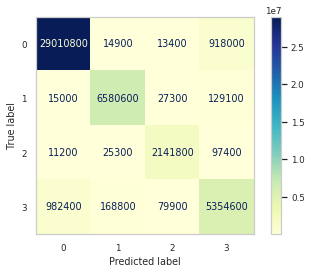

In [ ]:
cm = confusion_matrix(y_train , results_DT, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("DT_cm.png",bbox_inches='tight' )
files.download("DT_cm.png")


**Random Forest**

In [ ]:
random_state = 42

model_RF=RandomForestClassifier(random_state=random_state)

scores=cross_val_score(model_RF, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


array([0.94155315, 0.93796093, 0.93877674, 0.94030301, 0.94093485,
       0.93871662, 0.94257516, 0.94129571, 0.94100702, 0.93787916])

In [ ]:

model_RF=RandomForestClassifier(random_state=random_state)

results_RF=cross_val_predict(model_RF,X_train,y_train,cv=cvk)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

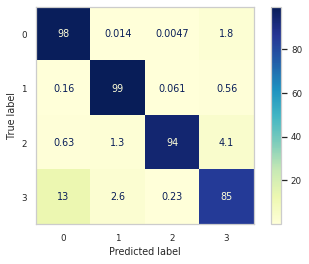

In [ ]:
cm = confusion_matrix(y_train , results_RF, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" )

plt.savefig("RF_cm.png",bbox_inches='tight')
files.download("RF_cm.png")


In [ ]:
print(classification_report(y_train,results_RF))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    299571
           1       0.97      0.99      0.98     67520
           2       0.99      0.94      0.96     22757
           3       0.89      0.85      0.87     65857

    accuracy                           0.96    455705
   macro avg       0.96      0.94      0.95    455705
weighted avg       0.96      0.96      0.96    455705



In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print("accuracy = " + str (accuracy_score(y_train,results_RF)))
print("precision = " + str (precision_score(y_train,results_RF,average="macro")))
print("recall = " + str (recall_score(y_train,results_RF,average="macro")))
print("F1 = " + str (f1_score(y_train,results_RF,average="macro")))
#print("FPR = " + str (FPR.mean()))

accuracy = 0.9614816602846139
precision = 0.956146563168813
recall = 0.9397249768758101
F1 = 0.9475711538618796
FPR = 0.019477085709269384


**Logistic Regression**

In [ ]:
random_state = 42

model_LR=LogisticRegression(random_state=random_state)

scores=cross_val_score(model_LR, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)


array([0.72878649, 0.73070038, 0.72282103, 0.71977834, 0.72095694,
       0.72560377, 0.72668243, 0.72414493, 0.72600254, 0.72395007])

In [ ]:
model_LR=LogisticRegression(random_state=random_state)

results_LR=cross_val_predict(model_LR,X_train,y_train,cv=cvk)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

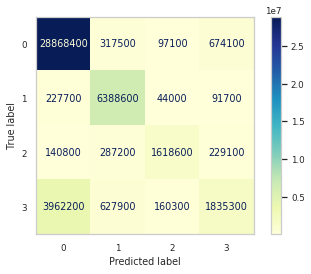

In [ ]:
cm = confusion_matrix(y_train , results_LR, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("LR_cm.png",bbox_inches='tight')
files.download("LR_cm.png")


**Catboost**

In [ ]:
! pip install catboost
from catboost import CatBoostClassifier


model_CB=CatBoostClassifier(random_state=random_state)

scores=cross_val_score(model_CB, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


array([0.92732242, 0.92336289, 0.92155435, 0.92210234, 0.92323351,
       0.92239893, 0.92643637, 0.92643037, 0.92590239, 0.92391792])

In [ ]:
! pip install catboost
from catboost import CatBoostClassifier

model_CB=CatBoostClassifier(random_state=random_state)

results_CB=cross_val_predict(model_CB,X_train,y_train,cv=cvk)

Streaming output truncated to the last 5000 lines.
4:	learn: 0.7508343	total: 3.08s	remaining: 10m 12s
5:	learn: 0.6931898	total: 3.64s	remaining: 10m 2s
6:	learn: 0.6446799	total: 4.11s	remaining: 9m 43s
7:	learn: 0.6028777	total: 4.75s	remaining: 9m 49s
8:	learn: 0.5648438	total: 5.36s	remaining: 9m 50s
9:	learn: 0.5351391	total: 5.89s	remaining: 9m 42s
10:	learn: 0.5062218	total: 6.59s	remaining: 9m 52s
11:	learn: 0.4807921	total: 7.24s	remaining: 9m 56s
12:	learn: 0.4595361	total: 7.76s	remaining: 9m 49s
13:	learn: 0.4395492	total: 8.41s	remaining: 9m 52s
14:	learn: 0.4219702	total: 9.07s	remaining: 9m 55s
15:	learn: 0.4065551	total: 9.7s	remaining: 9m 56s
16:	learn: 0.3915150	total: 10s	remaining: 9m 39s
17:	learn: 0.3778678	total: 10.4s	remaining: 9m 25s
18:	learn: 0.3663740	total: 10.8s	remaining: 9m 15s
19:	learn: 0.3557586	total: 11s	remaining: 9m 1s
20:	learn: 0.3458646	total: 11.4s	remaining: 8m 49s
21:	learn: 0.3367980	total: 11.7s	remaining: 8m 40s
22:	learn: 0.3289561	tot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

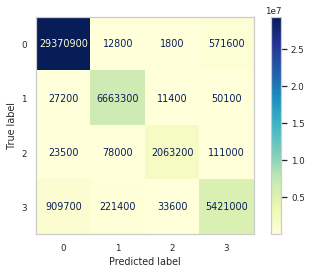

In [ ]:
cm = confusion_matrix(y_train , results_CB, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("CB_cm.png",bbox_inches='tight')
files.download("CB_cm.png")


In [ ]:
print(classification_report(y_train,results_CB))


              precision    recall  f1-score   support

           0       0.97      0.98      0.97    299571
           1       0.96      0.99      0.97     67520
           2       0.98      0.91      0.94     22757
           3       0.88      0.82      0.85     65857

    accuracy                           0.95    455705
   macro avg       0.95      0.92      0.93    455705
weighted avg       0.95      0.95      0.95    455705



In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
print("accuracy = " + str (accuracy_score(y_train,results_CB)))
print("precision = " + str (precision_score(y_train,results_CB,average="macro")))
print("recall = " + str (recall_score(y_train,results_CB,average="macro")))
print("F1 = " + str (f1_score(y_train,results_CB,average="macro")))
print("FPR = " + str (FPR.mean()))

accuracy = 0.9549686749103038
precision = 0.9455832545356063
recall = 0.9242661073703923
F1 = 0.9342697516623577
FPR = 0.022357322185223454


In [ ]:
cm = confusion_matrix(y_train , results_CB, )
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [ ]:
FPR.mean()

0.019477085709269384

In [ ]:
import cPickle

path="/content/gdrive/My Drive/datasets/model/model_cp_DT.pkl"

with open(path, 'wb') as f:
    cPickle.dump(model_DT, f)

In [ ]:
import pickle

path="/content/gdrive/My Drive/datasets/model/model_LR.pkl"
with open(path, 'rb') as f:
    model_LR = pickle.load(f)

**AdaBoost Logistic Regression as a base estimator**

In [ ]:
model_LR=LogisticRegression(random_state=random_state)
model_AB=AdaBoostClassifier(model_LR)

scores=cross_val_score(model_AB, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


array([0.69387635, 0.69543754, 0.68823882, 0.68648357, 0.68349733,
       0.68818724, 0.69243723, 0.68932674, 0.6870505 , 0.69089477])

In [ ]:
model_AB=AdaBoostClassifier(model_LR)

results_AB=cross_val_predict(model_AB,X_train,y_train,cv=cvk)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

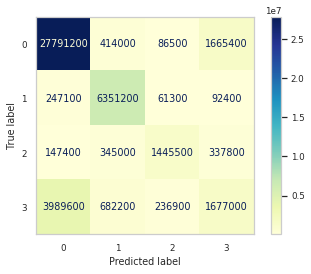

In [ ]:
cm = confusion_matrix(y_train , results_AB, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')
plt.savefig("AB_cm.png",bbox_inches='tight')
files.download("AB_cm.png")


**LightGBM**

In [ ]:
model_LGB = lgb.LGBMClassifier()
scores=cross_val_score(model_LGB, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)


array([0.91413015, 0.91198577, 0.91100822, 0.9112089 , 0.9107739 ,
       0.90936354, 0.91589788, 0.91274167, 0.91400941, 0.91191822])

In [ ]:
model_LGB = lgb.LGBMClassifier()

results_LGB=cross_val_predict(model_LGB,X_train,y_train,cv=cvk)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

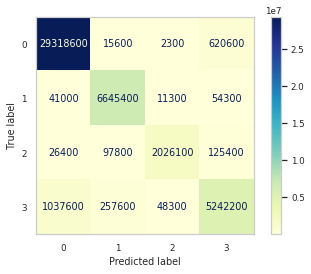

In [ ]:
cm = confusion_matrix(y_train , results_LGB, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("LGB_cm.png",bbox_inches='tight')
files.download("LGB_cm.png")


**Stochastic Gradient Descent**

In [ ]:
model_SGD = SGDClassifier(random_state=random_state)

scores=cross_val_score(model_SGD, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

array([0.68116704, 0.68552646, 0.6800231 , 0.68217113, 0.67399373,
       0.68119783, 0.68543234, 0.68197112, 0.68206836, 0.67757115])

In [ ]:
model_SGD = SGDClassifier(random_state=random_state)

results_SGD=cross_val_predict(model_SGD,X_train,y_train,cv=cvk)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

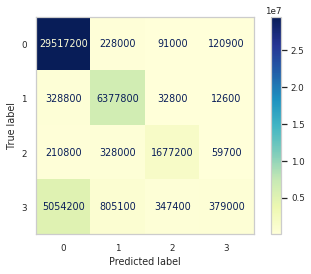

In [ ]:
cm = confusion_matrix(y_train , results_SGD, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("SGD_cm.png",bbox_inches='tight')
files.download("SGD_cm.png")


**Ridge Classifier**

In [ ]:
model_RC = RidgeClassifier()
cross_val_score(model_RC, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)

cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

array([0.68116704, 0.68552646, 0.6800231 , 0.68217113, 0.67399373,
       0.68119783, 0.68543234, 0.68197112, 0.68206836, 0.67757115])

array([0.68116704, 0.68552646, 0.6800231 , 0.68217113, 0.67399373,
       0.68119783, 0.68543234, 0.68197112, 0.68206836, 0.67757115])

In [ ]:
model_RC = RidgeClassifier()

results_RC=cross_val_predict(model_RC,X_train,y_train,cv=cvk)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

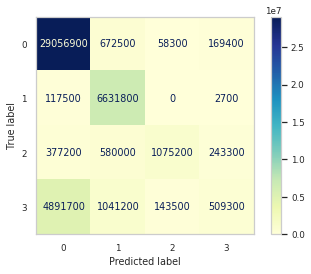

In [ ]:
cm = confusion_matrix(y_train , results_RC, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("RC_cm.png",bbox_inches='tight')
files.download("RC_cm.png")


**Collecting results**

In [ ]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree",
"RandomForest","LogisticRegression","CatBoostClassifier","AdaBoost","LightGBM"," StochasticGradientDescent","RidgeClassifier"]})

In [ ]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.924313,0.001828,DecisionTree
1,0.940100,0.001562,RandomForest
2,0.724943,0.003181,LogisticRegression
3,0.924266,0.001973,CatBoostClassifier
4,0.689543,0.003456,AdaBoost
5,0.912304,0.001829,LightGBM
6,0.681112,0.003245,StochasticGradientDescent
7,0.681112,0.003245,RidgeClassifier


In [ ]:
inplace=True
temp=cv_res

In [ ]:
temp = cv_res.drop(axis=0,index=6 )

In [ ]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.945520,0.001098,DecisionTree
1,0.961734,0.000694,RandomForest
2,0.849473,0.001405,LogisticRegression
3,0.954969,0.000862,CatBoostClassifier
4,0.817742,0.001948,AdaBoost
5,0.948690,0.000748,LightGBM
6,0.832802,0.001521,StochasticGradientDescent
7,0.832802,0.001521,RidgeClassifier


In [ ]:
temp

,CrossValMeans,CrossValerrors,Algorithm
0,0.945520,0.001098,DecisionTree
1,0.961734,0.000694,RandomForest
2,0.849473,0.001405,LogisticRegression
3,0.954969,0.000862,CatBoostClassifier
4,0.817742,0.001948,AdaBoost
5,0.948690,0.000748,LightGBM
6,0.832802,0.001521,StochasticGradientDescent
7,0.832802,0.001521,RidgeClassifier


In [ ]:
temp = temp.drop(axis=0,index=2)

In [ ]:
temp=temp.reset_index(drop=True)

temp

,CrossValMeans,CrossValerrors,Algorithm
0,0.924313,0.001828,DecisionTree
1,0.940100,0.001562,RandomForest
2,0.924266,0.001973,CatBoostClassifier
3,0.689543,0.003456,AdaBoost
4,0.912304,0.001829,LightGBM
5,0.681112,0.003245,RidgeClassifier


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

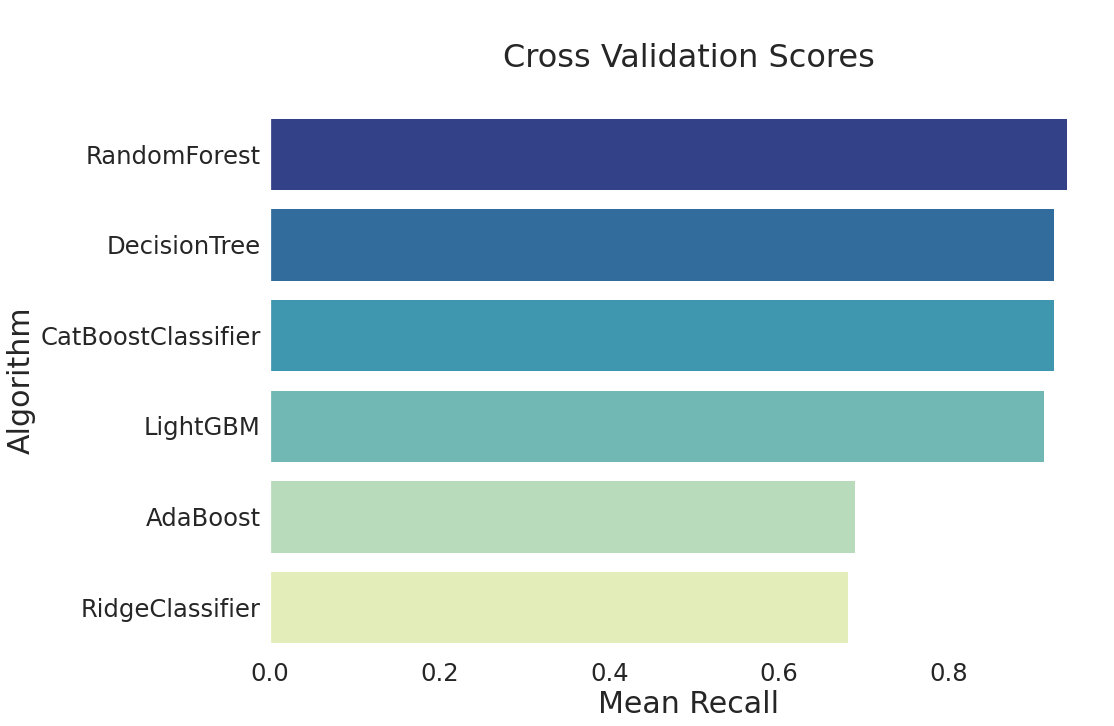

In [ ]:
plt.figure(figsize=(15, 10))


sns.set(font_scale=2.2 )
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'},font_scale=2.2)

g = sns.barplot("CrossValMeans","Algorithm",data = temp.sort_values(["CrossValMeans"],ascending=False), palette="YlGnBu_r",orient = "h",  );
g.set_xlabel("Mean Recall", size = 30);
g.set_ylabel("Algorithm", size = 30);
g = g.set_title("\nCross Validation Scores\n", size = 32);


plt.savefig("all_score.png",bbox_inches='tight')
files.download("all_score.png")


The above figure shows the Mean recall for each classifier across four folds.

It can be seen that the Random forest classifer has the highest mean, therefore we will be using the  Random forest classifer in our analysis.

To improve our model performance and to decrease the risk of overfitting, we will be using the GridSearchCV function to search for the best paramters for our model.

**hyperparameters tunning**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


random_state = 42

model_RF=RandomForestClassifier(random_state=random_state)


param_grid = {
    'n_estimators': [100 ,200, 500],
    'max_features': ['auto', 'log2'],
    'max_depth' : [ 18 , 22 , 25],
}

RF_GridSCV = GridSearchCV(estimator=model_RF, param_grid=param_grid, cv= 4)
RF_GridSCV.fit(X_train, y_train)

In [ ]:
RF_GridSCV.best_params_

In [ ]:
model_RF_BP = RandomForestClassifier(random_state=random_state,max_depth= 25 ,n_estimators=200)

model_RF_BP_results = cross_val_predict(model_RF_BP,X_train,y_train,cv=cvk)

In [ ]:
cm = confusion_matrix(y_train , model_RF_BP_results )
ncm=cm /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm )
disp.plot(cmap="magma")

plt.savefig("RF_GSCVBP_cm.png",bbox_inches='tight')
files.download("RF_GSCVBP_cm.png")

**random Forest with hyper paramters evaluation**

In [ ]:
print(classification_report(y_train,model_RF_BP_results))

In [ ]:
model_RF_BP.fit(X_train,y_train) #to test on the training set

RandomForestClassifier(max_depth=25, n_estimators=200, random_state=42)

In [ ]:
model_RF_BP_results_tra=model_RF_BP.predict(X_train)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
print("accuracy = " + str (accuracy_score(y_train,model_RF_BP_results_tra)))
print("precision = " + str (precision_score(y_train,model_RF_BP_results_tra,average="macro")))
print("recall = " + str (recall_score(y_train,model_RF_BP_results_tra,average="macro")))
print("F1 = " + str (f1_score(y_train,model_RF_BP_results_tra,average="macro")))


accuracy = 0.9825654754720707
precision = 0.9799523439473379
recall = 0.9720409000719419
F1 = 0.975885508847285


In [ ]:
print(classification_report(y_train,model_RF_BP_results_tra))

In [ ]:
model_RF_BP_results_test=model_RF_BP.predict(X_test) #testing on the test set

In [ ]:
print(classification_report(y_test,model_RF_BP_results_test))

**The Vanilla Random Forest Classifier (with the default hyperparamters) evaluation.**



In [ ]:
model_RF=RandomForestClassifier(random_state=random_state)

model_RF.fit(X_train,y_train)


RandomForestClassifier(random_state=42)

In [ ]:
y_pred_train=model_RF.predict(X_train)

In [ ]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299571
           1       1.00      1.00      1.00     67520
           2       1.00      0.98      0.99     22757
           3       0.98      0.98      0.98     65857

    accuracy                           0.99    455705
   macro avg       0.99      0.99      0.99    455705
weighted avg       0.99      0.99      0.99    455705



In [ ]:
cm = confusion_matrix(y_train , y_pred_train, )
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
print("accuracy = " + str (accuracy_score(y_train,y_pred_train)))
print("precision = " + str (precision_score(y_train,y_pred_train,average="macro")))
print("recall = " + str (recall_score(y_train,y_pred_train,average="macro")))
print("F1 = " + str (f1_score(y_train,y_pred_train,average="macro")))
print("FPR = " + str (FPR.mean()))

accuracy = 0.9947071021823328
precision = 0.9938927134477408
recall = 0.9895556578111444
F1 = 0.9916970317394203
FPR = 0.00258688965467007


In [ ]:
y_pred=model_RF.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    128388
           1       0.97      0.99      0.98     28937
           2       0.99      0.94      0.96      9753
           3       0.89      0.85      0.87     28225

    accuracy                           0.96    195303
   macro avg       0.96      0.94      0.95    195303
weighted avg       0.96      0.96      0.96    195303



In [ ]:
cm = confusion_matrix(y_test , y_pred )
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
print("accuracy = " + str (accuracy_score(y_test , y_pred )))
print("precision = " + str (precision_score(y_test , y_pred ,average="macro")))
print("recall = " + str (recall_score(y_test , y_pred ,average="macro")))
print("F1 = " + str (f1_score(y_test , y_pred ,average="macro")))
print("FPR = " + str (FPR.mean()))

accuracy = 0.9624839352186091
precision = 0.956901062383326
recall = 0.9415419851640711
F1 = 0.9488947209255345
FPR = 0.018894054441034494


We can see that our model achived 99% accuracy, recall and percision on the training set , on the other hand it only achived 96% accuracy on the test set , and 94% recall.

This indicates that the model overfits the training set badly.


**CatBoost model evaluation**

In [ ]:
! pip install catboost
from catboost import CatBoostClassifier

model_CB=CatBoostClassifier(random_state=random_state)

model_CB.fit(X_train,y_train)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 
Learning rate set to 0.108123
0:	learn: 1.1668578	total: 387ms	remaining: 6m 26s
1:	learn: 1.0180998	total: 717ms	remaining: 5m 57s
2:	learn: 0.9080129	total: 1.2s	remaining: 6m 38s
3:	learn: 0.8197238	total: 1.75s	remaining: 7m 16s
4:	learn: 0.7479215	total: 2.48s	remaining: 8m 13s
5:	learn: 0.6894039	total: 3.06s	remaining: 8m 27s
6:	learn: 0.6417551	total: 3.56s	remaining: 8m 24s
7:	learn: 0.6014852	total: 3.89s	remaining: 8m 2s
8:	learn: 0.5638708	total: 4.34s	remaining: 7m 58s
9:	learn: 0.5334365	total: 4.72s	remaining: 7m 47s
10:	learn: 0.5056053	total: 5.12s	remaining: 7m 39s
11:	learn: 0.4802890	total: 5.53s	remaining: 7m 35s
12:	learn: 0.4579759	total: 5.9s	remaining: 7m 28s
13:	learn: 0.4375505	total: 6.33s	remaining: 7m 25s
14:	learn: 0.4197312	total: 6.88s	remaining: 7m 31s
15:	learn: 0.4043857	total: 7.43s	remaining: 7

In [ ]:
y_pred_train_CB=model_CB.predict(X_train)

In [ ]:
cm = confusion_matrix(y_train , y_pred_train_CB, )
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
print("accuracy = " + str (accuracy_score(y_train,y_pred_train_CB)))
print("precision = " + str (precision_score(y_train,y_pred_train_CB,average="macro")))
print("recall = " + str (recall_score(y_train,y_pred_train_CB,average="macro")))
print("F1 = " + str (f1_score(y_train,y_pred_train_CB,average="macro")))
print("FPR = " + str (FPR.mean()))

accuracy = 0.9576853446857068
precision = 0.9501232813391288
recall = 0.9294726726559374
F1 = 0.939195306602495
FPR = 0.021162414575899235


In [ ]:
print(classification_report(y_train,y_pred_train_CB))

In [ ]:
y_pred_CB=model_CB.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test , y_pred_CB )
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
print("accuracy = " + str (accuracy_score(y_test , y_pred_CB )))
print("precision = " + str (precision_score(y_test , y_pred_CB ,average="macro")))
print("recall = " + str (recall_score(y_test , y_pred_CB ,average="macro")))
print("F1 = " + str (f1_score(y_test , y_pred_CB ,average="macro")))
print("FPR = " + str (FPR.mean()))

accuracy = 0.9553514282934722
precision = 0.9461957101203817
recall = 0.9243510176152405
F1 = 0.9345969123330012
FPR = 0.022192400538228352


In [ ]:
print(classification_report(y_test,y_pred_CB))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97    128388
           1       0.96      0.99      0.97     28937
           2       0.98      0.90      0.94      9753
           3       0.88      0.82      0.85     28225

    accuracy                           0.96    195303
   macro avg       0.95      0.92      0.93    195303
weighted avg       0.95      0.96      0.95    195303



# Deep Learning

We will try to get a better performance for our classification task by using more complex models such as deep learning.

But let us first obtain the validation set


In [ ]:
strat_train_set["type"]=strat_train_set["type"]
X_train_full=strat_train_set
Y_train_full=strat_train_set["type"]

X_test_full=strat_test_set.drop("type",axis=1)
Y_test_full=strat_test_set["type"]

In [ ]:
X_train_full.reset_index(drop=True,inplace=True)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
for train_index, test_index in split.split(X_train_full, Y_train_full):
    XY_train = X_train_full.loc[train_index]
    XY_valid = X_train_full.loc[test_index]

In [ ]:
X_train= XY_train.drop("type",axis=1)
Y_train_r= XY_train["type"]

X_valid=XY_valid.drop("type",axis=1)
Y_valid_r=XY_valid["type"]

X_test=X_test_full
Y_test_r=Y_test_full

we will use the to_categorical function to one-hot encode our labels

In [ ]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train_r, 4)
Y_valid = to_categorical(Y_valid_r, 4)
Y_test = to_categorical(Y_test_r, 4)

In [ ]:
X_train.shape

(410134, 63)

In [ ]:
keras.backend.clear_session()

**Model_1**

As a begining we will try a simple sequential deep learning model

Our initial model has 3 hidden layers, with 300, 200, 100 neurons respectively, we will use the relu activation function as it is easy to compute, the output layer will have 4 neurons which is equal to the number of classes we have, and we will use the softmax activation function in this layer,as our problem is considered a multi-class classifaction problem.

In [ ]:
model_1 = keras.models.Sequential()
model_1.add(keras.layers.Dense(300,input_dim=63, activation="relu"))
model_1.add(keras.layers.Dense(200, activation="relu"))
model_1.add(keras.layers.Dense(100, activation="relu"))
model_1.add(keras.layers.Dense(4, activation="softmax"))

In [ ]:
keras.utils.plot_model(model_1,  show_shapes=True)

In [ ]:
 model_1.summary()

Since the dataset is not balanced the accuracy metric is not a good one to evalutae our models  performance.

We will use the recall metrics instead of the accuracy, as detecting mallicious website is our main goal, and we also want to minimize the FN (False negative) rate as much as possible.

In [ ]:
model_1.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["Recall"])

In [ ]:
history = model_1.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

Training set scores

loss: 0.1383

recall: 0.9495




Validation set scores

loss: 0.1409

recall: 0.9482


There are the scores obtained from the previous model, it can be observed that the scores accutally gets better after every epoch, however the improvments is really slow let try the same model but this time we will use only two hidden layers having 200 and 100 neurons respectivly


**Model_2**

In [ ]:
model_2 = keras.models.Sequential()
model_2.add(keras.layers.Dense(200,input_dim=63, activation="relu"))
model_2.add(keras.layers.Dense(100, activation="relu"))
model_2.add(keras.layers.Dense(4, activation="softmax"))

model_2.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["Recall"])

In [ ]:
history2 = model_2.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))

Training set scores

loss: 0.1509

recall: 0.9443



Validation set scores

loss: 0.1516

recall: 0.9442

The first model performs alittle bit better than the second one, hence we will consider the same number of layers and nurones as in it and we will try to improve it more using some advanced techniques,

The recall so far is good,however, it can be noticed that the training improvment becomes too slow at the last epoches.

let check the weights of the first model, to see if we can address the problem

In [ ]:
weights, biases =model_1.layers[3].get_weights()

In [ ]:
weights

 the weights has many relatively large negative values, which probably causes a dying ReLU problem, therfore we should consider an alternative of the ReLU activation function.

let try the first model again, but this time we will use the SELU activation function, further more we will use the LeCun intializer, the combination of such intializer and activation function provide a property called self-normalization which helps in preventing the vanishing/exploding gradient problem , hence we except this new model to perform better.

We will also choose a large number of epochs along with an early stopping call back .

**Model_3**

In [ ]:
model_3 = keras.models.Sequential()
model_3.add(keras.layers.Dense(300,input_dim=63, activation="selu",kernel_initializer="lecun_normal"))
model_3.add(keras.layers.Dense(200, activation="selu",kernel_initializer="lecun_normal"))
model_3.add(keras.layers.Dense(100, activation="selu",kernel_initializer="lecun_normal"))
model_3.add(keras.layers.Dense(4, activation="softmax",kernel_initializer="lecun_normal"))

in our early stopping call back we will a patience of 10, which means that if the model's performacne didn't improve after 10 epochs, thn the training will stop, and the best weights will be restored in our case (restore_best_weights=True)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
model_3.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["Recall"])

In [ ]:
keras.utils.plot_model(model_3,  show_shapes=True)

In [ ]:
history3 = model_3.fit(X_train, Y_train, epochs=60, validation_data=(X_valid, Y_valid), callbacks=[early_stopping_cb])

Looking back at this model (model 3) statistics , we see that the scores are as follow:

Training set scores

loss: 0.1134  

recall: 0.9582




Validation set scores

loss: 0.1271

recall: 0.9551

which is better than the previous two models , still there is more room for improvments.

In [ ]:
plt.plot(history3.history['recall'])
plt.plot(history3.history['val_recall'])
plt.title('model reacall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

For the two figures above, we can see that the training loss constantly decrease in a uniform manner, this is not the case for the validation loss, it can be observed that at a certain point the loss no longer decrease uniformally, instead it keeps on decreasing but in a volatile (noisy) manner, furthermore the validation loss is higher than thats of the training loss, which indicates that our model is acctually overfitting the training set.

Let improve model_3 by using batch normalization to mitigate the problem of the vanshing gradient that happens during the training process not at the begining of it, we will also use the Nadam optimizer as well to speed up the training process, finally we will add a learning rate schedualing technique called "performance schedualing", this technique works by measuring the validation error after a specific number of steps, and reduce the learning rate by a specific factor when the error stops dropping.

note: the batch normalization will slow down the training for each epoch, however it will increase the performance. this performance increase might triggers the early stopping call back earlier leading to a less overall training time.

All of these techniques will also help with the overfitting problem

**Model_4**

In [ ]:
model_4 = keras.models.Sequential()
model_4.add(keras.layers.Dense(300,input_dim=63, activation="selu",kernel_initializer="lecun_normal"))
model_4.add(keras.layers.BatchNormalization())
model_4.add(keras.layers.Dense(200, activation="selu",kernel_initializer="lecun_normal"))
model_4.add(keras.layers.BatchNormalization())
model_4.add(keras.layers.Dense(100, activation="selu",kernel_initializer="lecun_normal"))
model_4.add(keras.layers.BatchNormalization())
model_4.add(keras.layers.Dense(4, activation="softmax",kernel_initializer="lecun_normal"))

In [ ]:
early_stopping_cb_2 = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
performance_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.4, patience=5)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
              metrics=["Recall"])

In [ ]:
keras.utils.plot_model(model_4,  show_shapes=True)

In [ ]:
history4 = model_4.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid),
                       callbacks=[early_stopping_cb_2,performance_scheduler])


In [ ]:
model_4.save("/content/gdrive/My Drive/datasets/model/DNN/model_4") # saving the model

In [ ]:
model_4.evaluate(X_valid,Y_valid)

The performance of our model has  decreased alittle bit compaired to the previous model  after adding the batch normalization.

Moreover the validation's recall performace stopped increasing after the 11th epoch when the validation recall was 0.9532, and our model stopped training after 10 epoches from that and rolled back it's weights to the values that was present at that time.

This model didn't get a better score compaired to the previous one; however, it did converge faster, this model (model_4) took 24 minutes to converge , on the other hand the previous one (model_3)  took  39 minutes.

As an improvment of this model, let add a dropout layer.

We will only add two dropout layers before the 2nd and 3rd hidden layers, each having a drop rate of 20%.

**Model_5**

In [ ]:
model_5 = keras.models.Sequential()
model_5.add(keras.layers.Dense(300,input_dim=63, activation="selu",kernel_initializer="lecun_normal"))
model_5.add(keras.layers.BatchNormalization())
model_5.add(keras.layers.Dropout(0.2)) #0.2
model_5.add(keras.layers.Dense(200, activation="selu",kernel_initializer="lecun_normal"))
model_5.add(keras.layers.BatchNormalization())
model_5.add(keras.layers.Dropout(0.2))
model_5.add(keras.layers.Dense(100, activation="selu",kernel_initializer="lecun_normal"))
model_5.add(keras.layers.BatchNormalization())
model_5.add(keras.layers.Dense(4, activation="softmax",kernel_initializer="lecun_normal"))

In [ ]:
early_stopping_cb_3 = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
performance_scheduler_2 = keras.callbacks.ReduceLROnPlateau(factor=0.4, patience=5)
model_5.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
              metrics=["Recall"])

In [ ]:
keras.utils.plot_model(model_5,  show_shapes=True)

In [ ]:
history5 = model_5.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), callbacks=[early_stopping_cb_3,performance_scheduler_2])

In [ ]:
model_5.evaluate(X_valid,Y_valid)

ValueError: ignored

In [ ]:
model_5.save("/content/gdrive/My Drive/datasets/model/DNN/model_5") # saving the model

It can be seen that this model has a better validation set recall compaired with the previous two models even though it ran for a longer time.

The validation and training recalls seems to be a little different, the validation recall is better than that of the training as can be seen from the output of the "fit" cell,this is because we have used the  dropout layer, hence to get the correct training loss me must evalute the model after training (i.e. without the dropout layer) .

In [ ]:
model_5.evaluate(X_valid,Y_valid)

In [ ]:
model_5.evaluate(X_train,Y_train)

As can be seen the training set and the validation has similar recall

Plotting the validation and training sets recall will not be very useful for us, as the plot will be missleading due to the fact that we have used the alpha dropout layer, however it can be seen that the plots accutally got flatten at the last 10 epoches

In [ ]:
plt.plot(history5.history['recall'])
plt.plot(history5.history['val_recall'])
plt.title('Model_5 Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Also by compairing the losses of the training and validation sets, we can clearly see that the training set curve flattens at the last epoches, while the validaion set jumps around the training set curve




still due to the early stopping call back our model stopped training on the 31 epoches and from the graph we see that the validation and the training sets are flatten on this epoch and the 5/6 epoches that follows, therefore it is safe to consider that this model the best one so far.

In [ ]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

The paper that introduced the self normalizing netowrk recommened the usage of a variant of the dropout layer called the alpha dropout layer,this layer keeps the mean and variance of inputs to their original values,therefore it ensure the self-normalizing property even after the dropout.

therefore in our last model, we will replace the dropout layers in the previous model with the alpha dropout layer, and keep everything the same.

**Model_6**

In [ ]:
model_6 = keras.models.Sequential()
model_6.add(keras.layers.Dense(300,input_dim=63, activation="selu",kernel_initializer="lecun_normal"))
model_6.add(keras.layers.BatchNormalization())
model_6.add(keras.layers.AlphaDropout(0.2)) #0.2
model_6.add(keras.layers.Dense(200, activation="selu",kernel_initializer="lecun_normal"))
model_6.add(keras.layers.BatchNormalization())
model_6.add(keras.layers.AlphaDropout(0.2))
model_6.add(keras.layers.Dense(100, activation="selu",kernel_initializer="lecun_normal"))
model_6.add(keras.layers.BatchNormalization())
model_6.add(keras.layers.Dense(4, activation="softmax",kernel_initializer="lecun_normal"))

early_stopping_cb_3 = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
performance_scheduler_2 = keras.callbacks.ReduceLROnPlateau(factor=0.4, patience=5)
model_6.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
              metrics=["Recall"])

In [ ]:
history6 = model_6.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), callbacks=[early_stopping_cb_3,performance_scheduler_2])

In [ ]:
model_6.save("/content/gdrive/My Drive/datasets/model/DNN/model_6") # saving the model

As can be seen the model performance didn't improve, in the contrary it acctually decreased alittle bit, hence this dropout layer didn't work well for us.

Let see all the models scores

In [ ]:
def f1(r,p):
    return (2/((1/r)+(1/p) ) )


In [ ]:
model_1.compile(loss="categorical_crossentropy",
              optimizer='sgd',
              metrics=["Recall","Precision","accuracy"])

_ ,r ,p ,a =model_1.evaluate(X_valid,Y_valid)
lis=[r ,p ,a,f1(r,p)]
scores1= np.array(lis)

model_2.compile(loss="categorical_crossentropy",
              optimizer='sgd',
              metrics=["Recall","Precision","accuracy"])

_ ,r ,p ,a =model_2.evaluate(X_valid,Y_valid)
lis=[r ,p ,a,f1(r,p)]
scores2= np.array(lis)


model_3.compile(loss="categorical_crossentropy",
              optimizer='sgd',
              metrics=["Recall","Precision","accuracy"])

_ ,r ,p ,a =model_3.evaluate(X_valid,Y_valid)
lis=[r ,p ,a,f1(r,p)]
scores3= np.array(lis)


model_4.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
              metrics=["Recall","Precision","accuracy"])

_ ,r ,p ,a =model_4.evaluate(X_valid,Y_valid)
lis=[r ,p ,a,f1(r,p)]
scores4= np.array(lis)

model_5.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
              metrics=["Recall","Precision","accuracy"])

_ ,r ,p ,a =model_5.evaluate(X_valid,Y_valid)
lis=[r ,p ,a,f1(r,p)]
scores5= np.array(lis)

model_6.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
              metrics=["Recall","Precision","accuracy"])

_ ,r ,p ,a =model_6.evaluate(X_valid,Y_valid)
lis=[r ,p ,a,f1(r,p)]
scores6= np.array(lis)




1425/1425 [==============================] - 5s 3ms/step - loss: 0.1805 - recall: 0.9438 - precision: 0.9459 - accuracy: 0.9446


In [ ]:
col=['recall','precision','accuracy','F1']
models=['Model_1','Model_2','Model_3','Model_4','Model_5','Model_6']
fullscores=np.concatenate([scores1[:,None], scores2[:,None], scores3[:,None], scores4[:,None],scores5[:,None], scores6[:,None]], axis=1).T

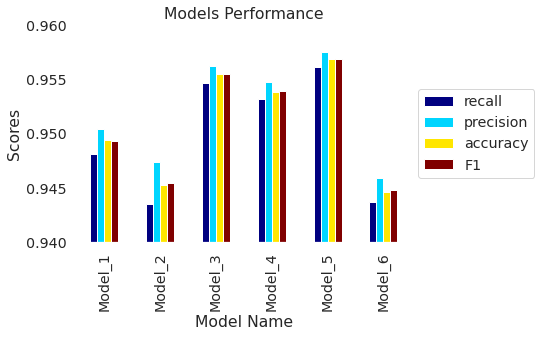

In [ ]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'},font_scale=1.3)
df3 = pd.DataFrame(fullscores, columns=col,index=models)
df3['models']=models
df3.plot.bar(ylim=(0.94,0.96) ,ylabel='Scores' ,xlabel='Model Name' , title='Models Performance',colormap="jet" ).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

As can be seen model_5 gives the best performance compaired to the other models, hence we will consider it as our final model.

**Evalutating model_5 performance**

The following are the scores of model_5 on all the sets

In [ ]:
model_5.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
              metrics=["Recall","Precision","accuracy"])

_ ,recall_5v ,precision_5v ,accuracy_5v =model_5.evaluate(X_valid,Y_valid)

1425/1425 [==============================] - 8s 4ms/step - loss: 0.1200 - recall: 0.9561 - precision: 0.9575 - accuracy: 0.9568 - false_positives: 1932.0000


ValueError: ignored

In [ ]:
_,recall_5tr ,precision_5tr ,accuracy_5tr =model_5.evaluate(X_train,Y_train)

12817/12817 [==============================] - 28s 2ms/step - loss: 0.1179 - recall: 0.9585 - precision: 0.9601 - accuracy: 0.9593


In [ ]:
_,recall_5t ,precision_5t ,accuracy_5t =model_5.evaluate(X_test,Y_test)

6104/6104 [==============================] - 15s 3ms/step - loss: 0.1362 - recall: 0.9554 - precision: 0.9570 - accuracy: 0.9561


In [ ]:
f1_5t = f1(recall_5t,precision_5t)

In [ ]:
f1_5tr = f1(recall_5tr,precision_5tr)

In [ ]:
f1_5v = f1(recall_5v,precision_5v)

The following plot shows the scores of each set using different metrics

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

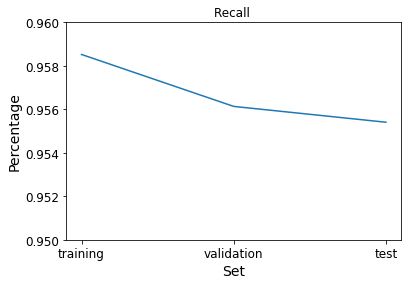

In [ ]:
x=["training","validation","test"]
y1=[recall_5tr,recall_5v, recall_5t]
y2=[precision_5tr,precision_5v, precision_5t]
y3=[accuracy_5tr,accuracy_5v, recall_5t]
plt.title("Recall ")
plt.xlabel("Set")
plt.ylabel("Percentage")
plt.ylim([0.95, 0.96])
plt.plot(x,y1)


plt.savefig("recall.png",bbox_inches='tight')
files.download("recall.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

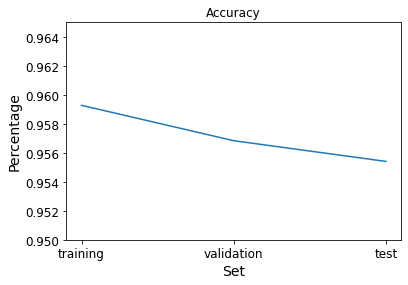

In [ ]:
x=["training","validation","test"]

y3=[accuracy_5tr,accuracy_5v, recall_5t]
plt.title("Accuracy")
plt.xlabel("Set")
plt.ylabel("Percentage", )
plt.ylim([0.95, 0.965])
plt.plot(x,y3)

plt.savefig("acc.png",bbox_inches='tight')
files.download("acc.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

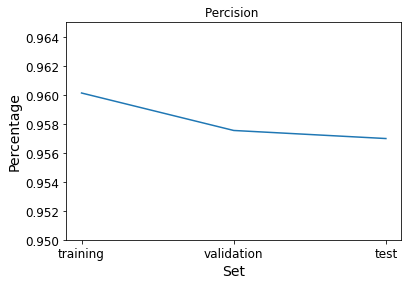

In [ ]:
x=["training","validation","test"]

y2=[precision_5tr,precision_5v, precision_5t]

plt.title("Percision ")
plt.xlabel("Set")
plt.ylabel("Percentage", )
plt.ylim([0.95, 0.965])
plt.plot(x,y2)

plt.savefig("precision.png",bbox_inches='tight')
files.download("precision.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

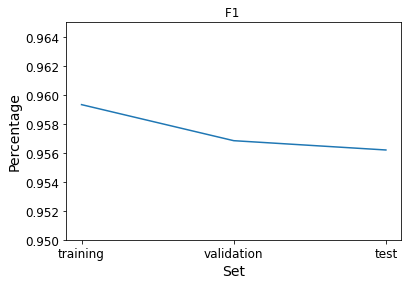

In [ ]:
x=["training","validation","test"]

y2=[f1_5tr,f1_5v, f1_5t]

plt.title("F1 ")
plt.xlabel("Set")
plt.ylabel("Percentage", )
plt.ylim([0.95, 0.965])
plt.plot(x,y2)

plt.savefig("F1.png",bbox_inches='tight')
files.download("F1.png")

From the above three figures we can see that our model slightly overfits the training set, it also adapted to the validation set, still this is a really small percentage of adaption, and the model's generalization was good

# More Useful features to add

the following is the implementation of some useful features that can be added to improve the overall performance of our model.

Unfortunatly we weren't able to add it because it requires alot of network requests which it pretty time consuming, for example to extract the below domain name features for just 100 instances it took us over 5 minutes to do it, even when using a local machine to run the code

# Domain name features

Now we begin with the features related to the domain name itself
such features include  :

1- Availability of a DNS record

2- Age of domain

3- Expiration time of Domain

In [ ]:
# we need to add such a libraries to make the code work
!pip install python-whois
import re
from bs4 import BeautifulSoup
import whois
import urllib
import urllib.request
from datetime import datetime

**Availability of a DNS record**

WHOIS is a protocol that is used to provide information services to the users of the internet, such informations include domain name, an IP address block or an autonomous system.

We will make use of such protocol to send a a query to the WHOIS database and check for the availability of a DNS record, malicious websites typically do not has such record as it lives for a short period of time.

the following is the type of response that we obtian from the WHOIS database, we will use the data in this response to extract more features

In [ ]:
whois.whois("facebook.com")

**Age of the doamin**

Using the response obtained from the WHOIS database we will extract this feature.

First we need to clarify that malicious websites typically live for a short period of time for many reasons for example if a malicious website lives for a long period and it conducted its malicious behaviour for a long period of time,such website will be known to the public and service providers will probably label such a website as malicious, hence when a user enter this website he will be faced with a warning.

furthermore perserving a domain name for a long period of time costs the attacker an amount of money,hence attackers tends to perservie domain names for a short period of time.

as can be seen from the above response, facebook has it's domain name preserved until 2031.

In this feature we will simpliy see if the age of the domain is older than 2 years (24 months) or not if its older then it will be set to 1 , otherwise it is set to zero

note: some of these information might be missing from the WHOIS response,which is unlickly to happen for begnin website, hence if any of such information is missing we will set the value of this feature for such instance to zero



0 for malicious

0.5 for not available

1 for benign

In [ ]:
def domainAge(domain_name):
  creation = domain_name.creation_date
  expiration = domain_name.expiration_date
  if (isinstance(creation,str) or isinstance(expiration,str)):
    try:
      creation = datetime.strptime(creation,'%Y-%m-%d')
      expiration = datetime.strptime(expiration,"%Y-%m-%d")
    except:
      return 0.5
  if ((expiration is None) or (creation is None)):
      return 0.5
  elif ((type(expiration) is list) or (type(creation) is list)):
      return 0.5
  else:
    ageofdomain = abs((expiration - creation).days)
    if ((ageofdomain/30) < 24):
      return 0
    else:
      return 1

**Expiration time of Domain**

Same as above it is useful to know much time is left for the website until its Domain name expire, however this time we will compare the expiration time from the WHOIS database with teh current time, and see if it has more than 1 year left until it expire

In [ ]:
def domainExpiration(domain_name): #this function always returns 0 needs fixing
  expiration = domain_name.expiration_date
  if isinstance(expiration,str):
    try:
      expiration = datetime.strptime(expiration,"%Y-%m-%d")
    except:
      return 0.5
  if (expiration is None):
      return 0.5
  elif (type(expiration) is list):
      return 0.5
  else:
    today = datetime.now()
    end = abs((expiration - today).days)
    if ((end/30) < 6):
      return 0
    else:
      return 1


Since all of such functions make use of the WHOIS database response we will warp it all in one function that extrat these three features

In [ ]:
def domain_features(url):
  #DNS record avilable or not
  dns = 1
  try:
    domain_name = whois.whois(url)
  except:
    return 0,0,0

  age = domainAge(domain_name)
  expiration = domainExpiration(domain_name)


  return dns, age ,expiration


In [ ]:
#df["domainFeatures"]=df['url'].apply(domain_features)

The above code retruns a tuple which is stored in the dateframe as an attribute called "domainFeatures" , the following function splits this tuple into three columns and drop the original column

In [ ]:
def domainFeaturesSplit(odf):
  odf[['DNS_available', 'DomainAge','DomainExpiration']] = pd.DataFrame(odf['domainFeatures'].tolist(), index=odf.index)
  odf.drop("domainFeatures",axis=1,inplace=True )


Calling our functions

In [ ]:
domainFeaturesSplit(df)

# HTML and JavaScript Features

These features are related to the website itself, to obtain it a request is sent to the webiste rather than a centralized server as what we did fro the domain name features above.

an example of these features are:


1- Website forwarding

2- Disabling Right Click

3- Status bar custumization

4- iFrame redirection


**Website forwarding**

This feature counts how many redirections is needed to reach the target website, usually malicious websites requires more redirections to reach

In [ ]:
def websiteForwarding(response):
  if response == "":
    return 0
  else:
    return len(response.history)

**Disabling Right Click**

Using javascript a website adminstrator can disable right clicks for various legitimate reasons ,however this feature is sometimes used in malicious websites in order to prevent the user from viewing the source code of the website or to prevent them from clicking on the "translate website" option.

In [ ]:
def disableRightClick(response):
  if response == "":
    return 0.5
  else:
    if re.findall(r"event.button ?== ?2", response.text):
      return 1
    else:
      return 0

**Status Bar Customization**

Using JavaScript you can customize the status bar shown for the usres, this feature can be exploited malicioulsly by showing fake URL instead of the real one to the users in order to trick them into beliving that this is a legitimate and safe website

In [ ]:

def statusBarCustomization(response):
  if response == "" :
    return 0.5
  else:
    if re.findall("<script>.+onmouseover=\"window.status=.+</script>", response.text):
      return 1
    else:
      return 0

**iFrame redirection**

Using iFrame you can display a website inside the currently used website, this can be used by a malicious entity to logically redirect you into another website while keeping the URL and all the attribute of the current website the same

iFrmae can be easily distinguished when its used, however it can be hidden by setting the iFrame border attribute.

We will extract this feature by checking whethere the website has an iFrame, and checking if it has changed the iFrame borders to make it invisible

In [ ]:
def iFrame(response):
  if response == "":
      return 0.5
  else:
      if re.findall(r"[<iframe>|<frameBorder>]", response.text):
          return 1
      else:
          return 0

*function to extract all of the above features*

In [ ]:
def htmlAndJsFeatures(url):
  try:
    response = requests.get(url)
  except:
    response = ""

  WebFwd = websiteForwarding(response)
  rclick = disableRightClick(response)
  sBarCus =statusBarCustomization(response)
  iframe= iFrame(response)


  return WebFwd, rclick ,sBarCus,iframe


In [ ]:
#df["htmlAndJsFeatures"]=df['url'].apply(htmlAndJsFeatures)

In [ ]:
def htmlAndJsSplit(odf):
  odf[['WebForwarding', 'RightClickDisabled','StatusBarCustomization','iFrame']] = pd.DataFrame(odf['htmlAndJsFeatures'].tolist(), index=odf.index)
  odf.drop("htmlAndJsFeatures",axis=1,inplace=True )

#Useful codes

a code to save a csv file into you google drive account directly
you need to mount your account first

In [ ]:
path="/content/gdrive/My Drive/datasets/filename.csv"

with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)

X_train
Y_train
X_valid
Y_valid

In [ ]:
from numpy import savetxt
savetxt('/content/gdrive/My Drive/datasets/modelsres/cv_mean_10k_macro.csv', cv_means, delimiter=',')

In [ ]:
from numpy import savetxt
savetxt('/content/gdrive/My Drive/datasets/modelsres/result_RF.csv', results_RF, delimiter=',')

In [ ]:
from numpy import loadtxt

results_CB = loadtxt('/content/gdrive/My Drive/datasets/modelsres/result_CB.csv', delimiter=',')

In [ ]:
from numpy import loadtxt

Y_test = loadtxt('/content/gdrive/My Drive/datasets/Y_test.csv', delimiter=',')
Y_valid = loadtxt('/content/gdrive/My Drive/datasets/Y_valid.csv', delimiter=',')
Y_train = loadtxt('/content/gdrive/My Drive/datasets/Y_train.csv', delimiter=',')

In [ ]:
X_train = pd.read_csv('/content/gdrive/My Drive/datasets/X_train.csv')
X_valid = pd.read_csv('/content/gdrive/My Drive/datasets/X_valid.csv')
X_test = pd.read_csv('/content/gdrive/My Drive/datasets/X_test.csv')
X_train.drop("Unnamed: 0",axis=1,inplace=True)
X_valid.drop("Unnamed: 0",axis=1,inplace=True)
X_test.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
X_train.drop("Unnamed: 0",axis=1,inplace=True)
X_valid.drop("Unnamed: 0",axis=1,inplace=True)
X_test.drop("Unnamed: 0",axis=1,inplace=True)

KeyError: ignored

In [ ]:
from numpy import loadtxt

cv_means = loadtxt('/content/gdrive/My Drive/datasets/cv_means.csv', delimiter=',')
cv_std = loadtxt('/content/gdrive/My Drive/datasets/cv_std.csv', delimiter=',')

Saving a keras model

In [ ]:
model_1.save("/content/gdrive/My Drive/datasets/model/DNN/model_1")

Loading a keras model

In [ ]:
model_1 = keras.models.load_model("/content/gdrive/My Drive/datasets/model/DNN/model_1")

In [ ]:
model_2 = keras.models.load_model("/content/gdrive/My Drive/datasets/model/DNN/model_2")

In [ ]:
model_3 = keras.models.load_model("/content/gdrive/My Drive/datasets/model/DNN/model_3")

In [ ]:
model_4 = keras.models.load_model("/content/gdrive/My Drive/datasets/model/DNN/model_4")

In [ ]:
model_5 = keras.models.load_model("/content/gdrive/My Drive/datasets/model/DNN/model_5")

In [ ]:
model_6 = keras.models.load_model("/content/gdrive/My Drive/datasets/model/DNN/model_6")

Saving a keras model history

In [ ]:
np.save('/content/gdrive/My Drive/datasets/model/DNN/history/model_6_history.npy',history6.history)

loading keras model history

In [ ]:
history5=np.load('/content/gdrive/My Drive/datasets/model/DNN/history/model_5_history.npy',allow_pickle='TRUE').item()